---
## I. Preliminaries
 > A. Imports\*

 > B. Data

---

 *<small>Required.</small>

### A. Imports
* Mount and navigate to Google Drive, import dependencies.

* Training in this notebook was mostly done on free tier GPU runtime with standard RAM.

> Mount drive if not automatically done when runtime reactivated (can also use sidepanel to the left):

In [0]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

> Install necessary libraries and dependencies:

In [0]:
#Required over !pip install transformers for subclassing model/overriding methods.
!git clone https://github.com/huggingface/transformers.git
%cd transformers
!pip install .

> Install HuggingFace Transformers as our main library for training and generation with GPT-2.

In [0]:
%tensorflow_version 2.x
from transformers import GPT2Tokenizer, GPT2DoubleHeadsModel, GPT2LMHeadModel, PreTrainedModel

> Subclass GPT-2 models to overwrite repetition penalty method so that it doesn't penalize punctuation.

In [0]:
class GPT2DoubleHeadsModelRP(GPT2DoubleHeadsModel):
    def enforce_repetition_penalty_(self, lprobs, batch_size, num_beams, prev_output_tokens, repetition_penalty):
        """repetition penalty (from CTRL paper https://arxiv.org/abs/1909.05858). """
        for i in range(batch_size * num_beams):
            for previous_token in set(prev_output_tokens[i].tolist()):
                if not tokenizer.decode(previous_token) in string.punctuation:
                    # if score < 0 then repetition penalty has to multiplied to reduce the previous token probability
                    if lprobs[i, previous_token] < 0:
                        lprobs[i, previous_token] *= repetition_penalty
                    else:
                        lprobs[i, previous_token] /= repetition_penalty

class GPT2LMHeadModelRP(GPT2LMHeadModel):
    def enforce_repetition_penalty_(self, lprobs, batch_size, num_beams, prev_output_tokens, repetition_penalty):
        """repetition penalty (from CTRL paper https://arxiv.org/abs/1909.05858). """
        for i in range(batch_size * num_beams):
            for previous_token in set(prev_output_tokens[i].tolist()):
                if not tokenizer.decode(previous_token) in string.punctuation:
                    # if score < 0 then repetition penalty has to multiplied to reduce the previous token probability
                    if lprobs[i, previous_token] < 0:
                        lprobs[i, previous_token] *= repetition_penalty
                    else:
                        lprobs[i, previous_token] /= repetition_penalty             

> Import necessary modules and tools for data manipulation and visualization:

In [0]:
import string, csv, re, random, logging, torch, io
from string import punctuation as punk
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ipywidgets import *
import seaborn as sns
import pandas as pd
import numpy as np

> Import and instantiate writer for adding graph of model, inputs to TensorBoard in main generation section.

In [0]:
try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

> When Transformers installed in root, we must navigate to main project folder in mounted My Drive. 

> Assumes the following structure:
<pre>.
├── content
│   ├──drive                         # Mounted drive folder.
│   │   └── My Drive                 # Mounted drive folder.
│   │       └── CSC-594-ADL          # Main project folder.
│   │           ├── datasets         # ConceptNet and ROCStories.
│   │           ├── endings          # Correct and generated endings per model.
│   │           ├── evals            # Evaluation results for stories and endings per model.
│   │           ├── models           # Pretrained models, tokenizers, vocabulary, etc.
│   │           ├── scripts          # Scripts for training and generation.
│   │           └── stories          # Combined story bodies and generated endings per model.
│   ├── sample_data                  # Default Colab folder.
│   └── transformers                 # Installed from HuggingFace.
└── ...
</pre>

In [0]:
%cd ../drive/My Drive/csc594-ADL

> Load TensorBoard for notebook.

In [0]:
%load_ext tensorboard

> Run to display TensorBoard below:

In [0]:
# %tensorboard --logdir runs

### B. Data
* Create/write data necessary for language modeling.
* Not necessary to run this, as data has been created.

Create and write to train/val/test .txts via generated ConceptNet sentences and ROCStories unlabeled training data:

In [0]:
def create_train_test(filename: str = None, lines: list = None) -> None:
    """Create train/val/test txts from list of lines from file."""
    held_out_lines = []
    test_lines = set()
    
    # Get lines to create dev, test sets.
    n = len(lines) * 0.05
    for idx in range(len(lines)):
        line = random.choice(lines)
        if len(held_out_lines) <= n:
            held_out_lines.append(line)
            lines.remove(line)

    # Test set, leave remainder for validation.
    hn = len(held_out_lines) * 0.5
    for idx in range(len(held_out_lines)):
        hline = random.choice(held_out_lines)
        if len(test_lines) <= hn:
            test_lines.add(re.sub("_sep_", ",", hline))
            held_out_lines.remove(hline)

    # Assumes we are in main project folder.
    with open(f'datasets/{filename}_train.txt', 'w') as train_file:
        train_file.write(re.sub("_sep_", "", "".join(lines)))
    with open(f'datasets/{filename}_val.txt', 'w') as val_file:
        val_file.write(re.sub("_sep_", "", "".join(held_out_lines)))
    with open(f'datasets/{filename}_test.txt', 'w') as test_file:
        test_file.write("".join(list(test_lines)))
        
def create_data(typ: str):
    """Create and write train/val/test .txts."""

    def get_roc(roc_file: str) -> list:
        """Obtain stories, endings from ROC training files."""
        roc_df = pd.read_csv(roc_file, sep=',')
        roc_df['split'] = np.random.randn(roc_df.shape[0], 1)
        mask = np.random.rand(len(roc_df)) <= 0.95
        train = roc_df[mask]
        held_out = roc_df[~mask]
        hmask = np.random.rand(len(held_out)) <= 0.5
        val = held_out[hmask]
        test = held_out[~hmask]
        filename = roc_file.replace(".csv", "")
        train.to_csv(f'{filename}_train.txt', header=None, index=False)
        val.to_csv(f'{filename}_val.txt', header=None, index=False)
        test.to_csv(f'{filename}_test.csv', index=False)

    if typ == "ROC":
        roc2016 = 'datasets/ROCStoriesSpring2016.csv'
        roc2017 = 'datasets/ROCStoriesWinter2017.csv'
        df_16 = pd.read_csv(roc2016, sep=',')
        df_17 = pd.read_csv(roc2017, sep=',')
        df_167 = df_16.append(df_17)
        df_167.to_csv('roc_1617.csv', index=False)
        get_roc('roc_1617.csv')

    elif typ == "ConceptNet":
        cn_file = 'datasets/conceptnet_sentences100k.txt'
        with open(cn_file) as cn_train:
            cn_lines = cn_train.read().splitlines()
            for ix, line in enumerate(cn_lines):
                line += "\n"
                cn_lines[ix] = line
        create_train_test("conceptnet", cn_lines)

Select data to create/write:

In [0]:
create_inter = interactive(create_data, 
                           {'manual': True, 
                            'manual_name': 'Create/write data'}, 
                           typ=RadioButtons(options=['ROC', 
                                                     'ConceptNet'], 
                                            description='Source type'))
display(create_inter)

---
## II. Training
> A.Language Modeling

> B. Multi-task Fine-tuning
---

### A. Language Modeling

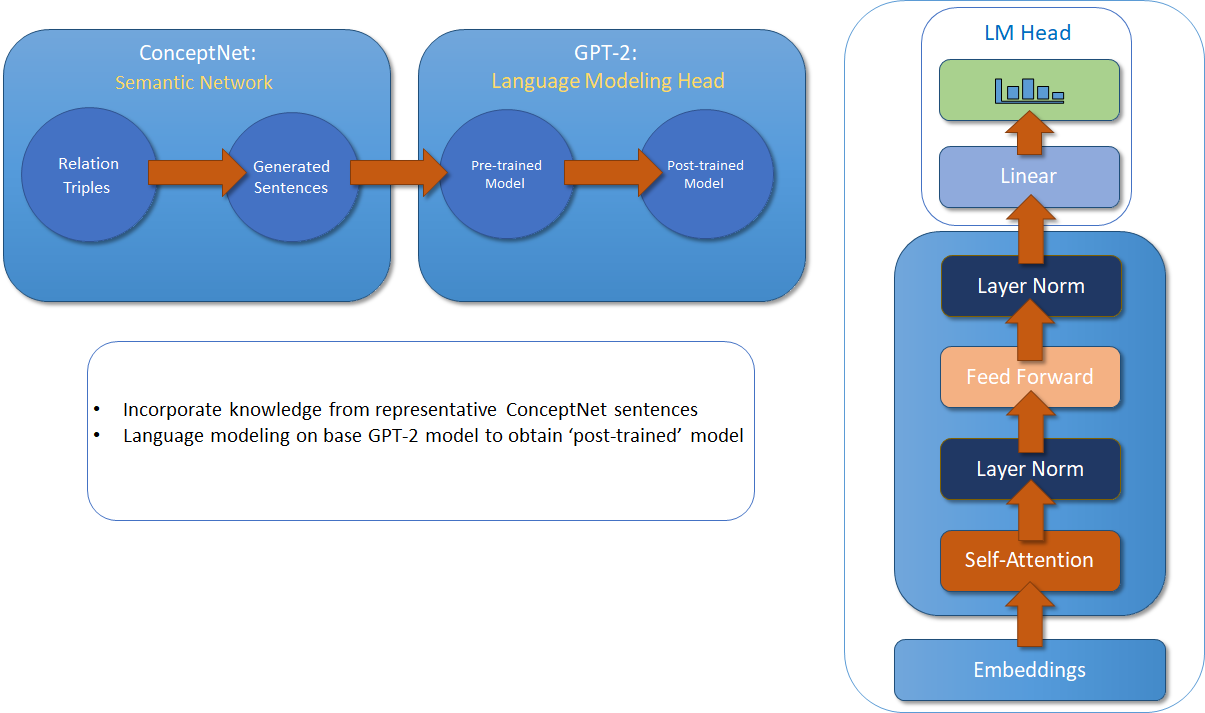

#### Arguments LM
* Define, display classes, model pipelines for language modeling script arguments.

##### Define LM args

In [0]:
class LM():
    """Class to perform single head LM on ConceptNet and/or ROCStories."""

    def __init__(self, typ='', do_train='', 
                            output_dir=None, 
                            n_or_p='gpt2', 
                            overwrite=''):
        self.typ = typ
        self.do_train = do_train
        self.do_eval = '--do_eval'
        self.overwrite_output_dir = overwrite
        self.per_gpu_train_batch_size = '--per_gpu_train_batch_size=2'
        self.model_type = '--model_type=gpt2'
        if typ == 'ConceptNet' or typ == 'cn':
            self.typ = "ConceptNet"
            if not output_dir:
                output_dir = '--output_dir=../models/conceptnet'
            self.output_dir = output_dir
            self.model_name_or_path = n_or_p
            self.train_data_file = '--train_data_file=datasets/conceptnet_train.txt'
            self.eval_data_file = '--eval_data_file=datasets/conceptnet_val.txt'
        elif typ.lower() == 'roc':
            self.typ = "ROC"
            if not output_dir:
                output_dir = '--output_dir=../models/roc1617'
            self.output_dir = output_dir
            self.model_name_or_path = n_or_p
            self.train_data_file = '--train_data_file=datasets/roc_1617_train.txt'
            self.eval_data_file = '--eval_data_file=datasets/roc_1617_val.txt'
    
    def __str__(self):
        """Pretty print attributes."""
        return "\n".join([
            "Type: " + self.typ,
            self.output_dir,
            self.model_type,
            self.model_name_or_path,
            '--do_train == ' + str(bool(self.do_train)),
            self.train_data_file,
            '--do_eval == ' + str(bool(self.do_eval)),
            self.eval_data_file,
            self.per_gpu_train_batch_size,
            self.overwrite_output_dir])
        
    def run_lm(self):
        """Run LM training script."""
        !python scripts/run_language_modeling.py \
            {self.output_dir} \
            {self.model_type} \
            {self.model_name_or_path} \
            {self.do_train} \
            {self.train_data_file} \
            {self.do_eval} \
            {self.eval_data_file} \
            {self.per_gpu_train_batch_size} \
            {self.overwrite_output_dir}

def get_LM_args(typ: str, 
            do_train='',
            output_dir=None,
            n_or_p='gpt2',
            overwrite='',
            show = True) -> list:
        """Instantiate language modeling argument class."""
        do_train = do_train
        overwrite_output_dir = overwrite
        if output_dir == 'May leave blank.':
            output_dir = None
        if typ == 'cn' or typ == 'ConceptNet':
            if not output_dir:
                output_dir = 'conceptnet'
            output_dir = f'--output_dir=../models/{output_dir}'
            n_or_p = f'--model_name_or_path={n_or_p}'
        elif typ.lower() == 'roc':
            if not output_dir:
                output_dir = 'roc1617'
            output_dir = f'--output_dir=../models/{output_dir}'
            n_or_p = f'--model_name_or_path={n_or_p}'
        args_LM = LM(typ, do_train, output_dir, n_or_p, overwrite)
        if show:
            print("Results:\n", args_LM)
        return args_LM

def call_get_LM_args(pipeline: str, do_train, overwrite, show: bool = True) -> list:
    """Choose pipeline to get args."""
    if pipeline == 'ConceptNet':
        return get_LM_args(typ='cn', 
                           do_train=do_train,
                           overwrite=overwrite,
                           show=show)
    if pipeline == 'ROCStories':
        return get_LM_args(typ='roc', 
                           do_train=do_train,
                           overwrite=overwrite,
                           show=show)
    if pipeline == 'ROC to ConceptNet':
        return get_LM_args('cn', 
                            output_dir='b_roc_cn',
                            n_or_p='../models/roc1617',
                            do_train=do_train,
                            overwrite=overwrite,
                            show=show)
    if pipeline == 'ConceptNet to ROC':
        return get_LM_args('roc', 
                            output_dir='b_cn_roc',
                            n_or_p='../models/conceptnet',
                            do_train=do_train,
                            overwrite=overwrite,
                            show=show)

##### Select LM pipeline

In [0]:
pipe_disp = interactive(call_get_LM_args, 
                        pipeline=['ConceptNet', 
                                  'ROCStories',
                                  'ROC to ConceptNet',
                                  'ConceptNet to ROC'],
                        do_train=[('False (eval only)', ''), ('True', '--do_train')],
                        overwrite=[('False (don\'t overwrite out dir)', ''),
                                   ('True', '--overwrite_output_dir')],
                        show=[('Show args', True), ('Don\'t show args', False)])
pipe_disp.layout.height = '350px'
display(pipe_disp)

In [0]:
if pipe_disp.result:
    args_LM = pipe_disp.result

---
Run LM with arguments:

In [0]:
args_LM.run_lm()

---
### B. Multi-task Fine-tuning
* Define, display classes, model pipelines for MTL fine-tuning script arguments.

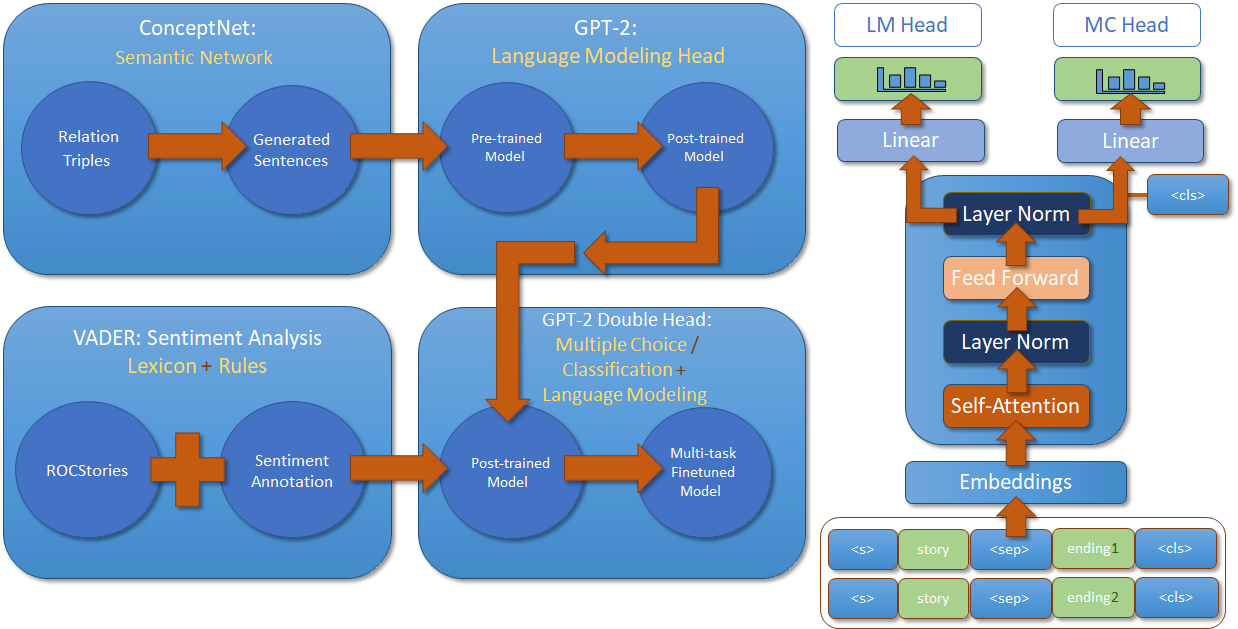

#### Arguments MTL
* Define, display classes, model pipelines for multitask finetuning script arguments.

##### Define MTL args

In [0]:
class MTL():
    """Class to perform single head LM on ConceptNet and/or ROCStories."""

    def __init__(self, typ = 'SCT', do_train='', 
                            output_dir=None, 
                            model_name=None):
        self.typ = typ
        self.do_train = do_train
        self.do_eval = '--do_eval'
        self.train_batch_size = '--train_batch_size=16'
        self.output_dir = f'--output_dir=../models/{output_dir}'
        if model_name:
            self.model_name = f'--model_name=../models/{model_name}'
        else:
            self.model_name = '--model_name=gpt2'
        if typ.lower() == 'sentiment':
            self.train_dataset = '--train_dataset=datasets/roc2018sentival.csv' # Labels based on sentiment congruity.
            self.eval_dataset = '--eval_dataset=datasets/roc2016sentitest.csv'
        else: # default Story Cloze Task (SCT)
            self.train_dataset = '--train_dataset=datasets/roc2018val.csv' # Original ROC test data, not LM test data.
            self.eval_dataset = '--eval_dataset=datasets/roc2016test.csv' # Original val data, not LM val data.

    def __str__(self):
        """Pretty print attributes."""
        return "\n".join([
            "Type: " + self.typ,
            self.model_name,
            '--do_eval == ' + str(bool(self.do_eval)),
            '--do_train == ' + str(bool(self.do_train)),
            self.train_dataset,
            self.eval_dataset,
            self.output_dir,
            self.train_batch_size])
        
    def run_mtl(self):
        """Run MTL finetuning script."""
        !python scripts/run_mtl.py \
            {self.model_name} \
            {self.do_eval} \
            {self.do_train} \
            {self.train_dataset} \
            {self.eval_dataset} \
            {self.output_dir} \
            {self.train_batch_size}

def get_MTL_args(typ: str, 
            do_train='',
            output_dir=None,
            model_name='',
            show = True) -> list:
        """Instantiate finetuning argument class."""
        do_train = do_train
        if output_dir == 'May leave blank.':
            output_dir = None
        if typ == 'cn' or typ == 'ConceptNet':
            if not output_dir:
                output_dir = f'conceptnet_{typ}'
            output_dir = f'--output_dir=../models/{output_dir}'
            model_name = f'--model_name={model_name}'
        elif typ.lower() == 'roc':
            if not output_dir:
                output_dir = f'roc1617_{typ}'
            output_dir = f'--output_dir=../models/{output_dir}'
            model_name = f'--model_name={model_name}'
        args_MTL = MTL(typ, do_train, output_dir, model_name)
        if show:
            print("Results:\n", args_MTL)
        return args_MTL

def call_get_MTL_args(pipeline: str, do_train, show: bool) -> list:
    """Choose pipeline to get args."""
    typ = 'SCT'
    model_name = ''
    output_dir = 'gpt2'
    if pipeline.startswith('Base'):
        # pipeline == 'Base' by default
        if pipeline == 'Base to SCT':
            output_dir='b_SCT'
        elif pipeline == 'Base to SCT to Sentiment':
            typ='Sentiment'
            output_dir='b_SCT_sentiment'
        elif pipeline == 'Base to Sentiment':
            typ='Sentiment'
            output_dir='b_sentiment'
        elif pipeline == 'Base to Sentiment to SCT':
            model_name='b_sentiment'
            output_dir='b_sentiment_sct'
    if pipeline.startswith('ConceptNet'):
        if pipeline == 'ConceptNet to SCT':
            model_name='conceptnet'
            output_dir='cn_SCT'
        elif pipeline == 'ConceptNet to Sentiment':
            typ='Sentiment'
            model_name='conceptnet'
            output_dir='cn_sentiment'
        elif pipeline == 'ConceptNet to ROC to Sentiment':
            typ='Sentiment'
            model_name='cn_roc'
            output_dir='cn_roc_sentiment'
        elif pipeline == 'CN to ROC to Sentiment to SCT':
            model_name='cn_roc_sentiment'
            output_dir='cn_roc_sentiment_sct'
        elif pipeline == 'ConceptNet to ROC to SCT':
            model_name='cn_roc'
            output_dir='cn_roc_SCT'
        elif pipeline == 'CN to ROC to SCT to Sentiment':
            typ='Sentiment'
            model_name='cn_roc_SCT'
            output_dir='cn_roc_SCT_sentiment'
        elif pipeline == 'CN to SCT to Sentiment':
            typ='Sentiment'
            model_name='cn_SCT'
            output_dir='cn_SCT_sentiment'
        elif pipeline == 'CN to Sentiment to SCT':
            model_name='cn_sentiment'
            output_dir='cn_sentiment_SCT'
    if pipeline.startswith('ROC'):
        if pipeline == 'ROC to SCT': 
            model_name='roc1617'
            output_dir='roc1617_SCT'
        elif pipeline == 'ROC to SCT to Sentiment':
            typ='Sentiment'
            model_name='roc1617_SCT'
            output_dir='roc1617_SCT_sentiment'
        elif pipeline == 'ROC to Sentiment': 
            typ='Sentiment'
            model_name='roc1617'
            output_dir='roc1617_sentiment'
        elif pipeline == 'ROC to CN to Sentiment':
            typ='Sentiment'
            model_name='roc_cn'
            output_dir='roc_cn_sentiment'
        elif pipeline == 'ROC to Sentiment to SCT':
            model_name='roc1617_sentiment'
            output_dir='roc1617_sentiment_SCT'
        elif pipeline == 'ROC to CN to SCT':
            model_name='roc_cn'
            output_dir='roc_cn_sct'
        elif pipeline == 'ROC to CN to SCT to Sentiment':
            typ='Sentiment'
            model_name='roc_cn_sct'
            output_dir='roc_cn_sct_sentiment'
        elif pipeline == 'ROC to CN to Sentiment to SCT':
            model_name='roc_cn_sentiment'
            output_dir='roc_cn_sentiment_sct'
    return get_MTL_args(typ=typ,
                        model_name=model_name,
                        output_dir=output_dir,
                        do_train=do_train,
                        show=show)

##### Select MTL pipeline

In [0]:
pipe_disp_MTL = interactive(call_get_MTL_args, 
                        pipeline=['Base',
                                  'Base to SCT',
                                  'Base to Sentiment',
                                  'Base to SCT to Sentiment',
                                  'Base to Sentiment to SCT',
                                  'ConceptNet to SCT', 
                                  'ConceptNet to Sentiment',
                                  'CN to SCT to Sentiment',
                                  'CN to Sentiment to SCT',
                                  'ConceptNet to ROC to SCT',
                                  'ConceptNet to ROC to Sentiment',
                                  'CN to ROC to SCT to Sentiment',
                                  'CN to ROC to Sentiment to SCT',
                                  'ROC to SCT',
                                  'ROC to Sentiment',
                                  'ROC to Sentiment to SCT',
                                  'ROC to SCT to Sentiment',
                                  'ROC to CN to SCT',
                                  'ROC to CN to SCT to Sentiment',
                                  'ROC to CN to Sentiment',
                                  'ROC to CN to Sentiment to SCT'],
                        do_train=[('False (eval only)', ''), ('True', '--do_train')],
                        show=[('Show args', True), ('Don\'t show args', False)])
pipe_disp_MTL.layout.height = '400px'
display(pipe_disp_MTL)

In [0]:
if pipe_disp_MTL.result:
    args_MTL = pipe_disp_MTL.result

Run MTL with arguments:

In [0]:
args_MTL.run_mtl()

---
## III. Generation
> A. Load data, models.

> B. Main generation functions.
---

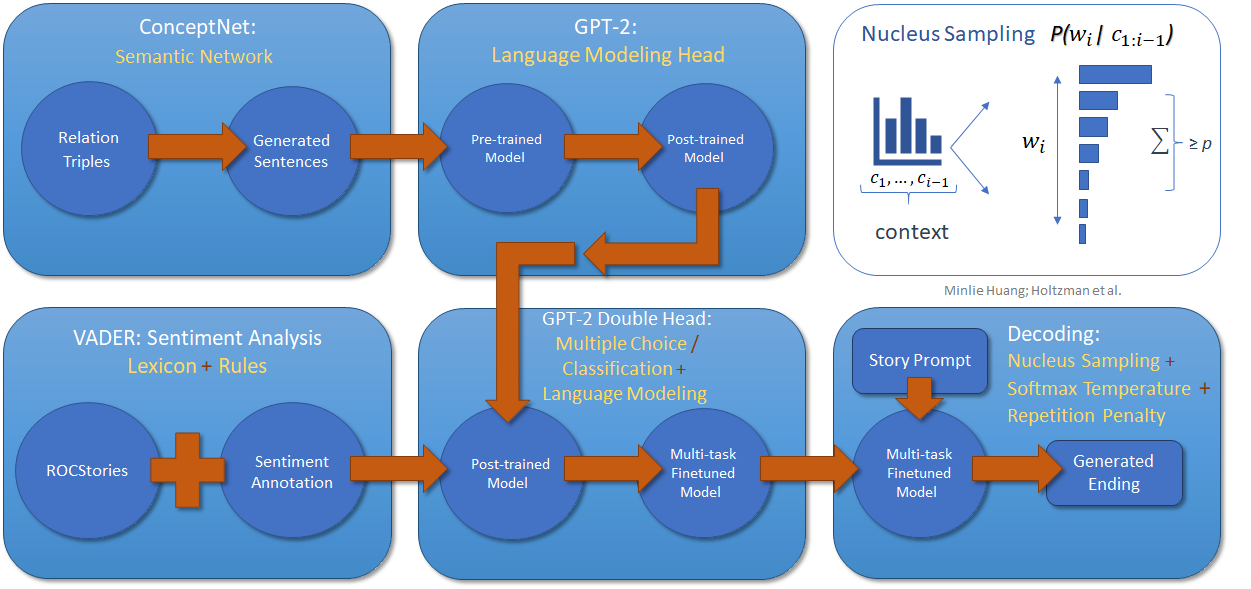

### A. Load data, models

Load vocabulary, weights from pretrained model(s), set evaluation mode and select device.

In [0]:
def get_model_gen(mpath: str='', typ: str='2', dev: str='cuda'):
    """Get subclassed model, tokenizer from pretrained."""
    logging.basicConfig(level=logging.INFO)
    tokenizer = GPT2Tokenizer.from_pretrained(mpath)
    if typ == "2":
        model = GPT2DoubleHeadsModelRP.from_pretrained(mpath, 
                                                       output_attentions=True)
    else:
        model = GPT2LMHeadModelRP.from_pretrained(mpath)
    model.eval() # deactivate dropout for reproducibility
    model.to(dev)
    return tokenizer, model

Define functions for loading and processing ROCStories data file for generation prompts.

In [0]:
def load_rocstories_dataset(dataset_path: str) -> list:
    """Output story, ending w/ special tokens."""
    sop = "_start_"
    eop = "_delimiter_"
    roc_df = pd.read_csv(dataset_path, sep=',', usecols=[2, 3, 4, 5, 6])
    df_endings = roc_df.sentence5
    df_stories = roc_df.loc[:, :'sentence4'].copy()
    story_bodies = df_stories.sentence1 + " " + df_stories.sentence2 + " " + df_stories.sentence3 + " " + df_stories.sentence4
    df_stories.sentence1 = sop + df_stories.sentence1
    df_stories.sentence4 = df_stories.sentence4 + eop
    return story_bodies, df_stories, df_endings

Paths to model, dataset.

In [0]:
def model_c(model: str) -> str:
    return model

model_chooser = interactive(model_c, model=[('Base to ConceptNet', 'conceptnet'),
                                            ('Base to ROC', 'roc1617'),
                                            ('Base to SCT', 'b_SCT'),
                                            ('Base to SCT to Sentiment', 'b_SCT_sentiment'),
                                            ('ConceptNet to SCT', 'cn_SCT'),
                                            ('ConceptNet to Sentiment', 'cn_sentiment'),
                                            ('CN to SCT to Sentiment', 'cn_SCT_sentiment'),
                                            ('CN to Sentiment to SCT', 'cn_sentiment_SCT'),
                                            ('ROC to SCT to Sentiment', 'roc1617_SCT_sentiment'),
                                            ('ROC to Sentiment to SCT', 'roc1617_sentiment_SCT'),
                                            ('ROC to SCT', 'roc1617_SCT')])
display(model_chooser)

Choose model, set path for test dataset to use for prompts, correct endings.

In [0]:
mname = 'gpt2'

if model_chooser.result:
    mname = model_chooser.result
dpath = "datasets/roc_1617_test.csv"

Run model data loading functions for generation:

In [0]:
story_bodies, df_stories, df_endings = load_rocstories_dataset(dpath)
stories = df_stories.join(df_endings).values.tolist()

In [0]:
if mname == 'gpt2': # For running base model.
    model_path = mname
else:
    model_path = f'models/{mname}'
tokenizer, model = get_model_gen(model_path)

### B. Main generation functions

a) Define functions to generate, collect results, write to files:

In [0]:
def get_text(prompt, model, tokenizer, add_to_tb, added: bool, mname:str) -> str:
    """Conditionally generate endings with model."""
    n = 53
    if mname == 'gpt2':
        n = 50
        prompt = prompt.replace("_start_", "") \
                       .replace("_delimiter_", "") \
                       .replace("_classify_", "")
    encoded_prompt = tokenizer.encode(prompt, 
                                      add_special_tokens=False, 
                                      return_tensors="pt")
    encoded_prompt = encoded_prompt.to("cuda")
    with torch.no_grad():
        output_sequences = model.generate(
            input_ids=encoded_prompt,
            bos_token_id=[tokenizer.bos_token_id, 50258], # _delimiter_
            pad_token_id=50256, # |endoftext|
            max_length=len(prompt.split(" ")) + n, # Give room for final sentence of ~30 tokens past input.
            temperature=0.7,
            eos_token_ids=[50256, 50259, 0, 30, 13], # 50259 _classify_; others: !?.
            top_k=20,
            top_p=0.9,
            repetition_penalty=1.2, # Modified to not punish frequent punctuation.
            do_sample=True,
            decoder_start_token_id=50258)
    if add_to_tb and not added:
        with SummaryWriter(comment='GPT2DoubleHeadsModel') as w:
            w.add_graph(model, encoded_prompt, verbose=False)
            added = True
    text = tokenizer.decode(output_sequences[0], 
                            clean_up_tokenization_spaces=True, 
                            skip_special_tokens=True)
    if not mname == 'gpt2':
        text = text.replace("_start_", "") \
                   .replace("_delimiter_", "") \
                   .replace("_classify_", "")
    else:
        text = text.replace("\n", "")
    return text

def write_stories(subtitle: str, stories: list, df_endings) -> None:
    """Write stories and endings to files."""
    endings = []
    df_endings_list = df_endings.values.tolist()
    with open(f"stories/seg_results_{subtitle}.txt", "w") as results_file:
        results_file.write(
        "Story\tCorrectEnding\tGenEnding\n")
        for ix, story in enumerate(stories):
            story = story.split("\t")
            try:
                gen_end = story[2]
            except:
                gen_end = "_none_"
            results_file.write(story[0] + "\t" + df_endings_list[ix] + "\t" + gen_end + "\n")
            endings.append((df_endings_list[ix], gen_end))
    write_endings(subtitle, endings)

def write_endings(subtitle: str, endings:list) -> None:
    """Write generated endings to file."""
    with open(f"endings/{subtitle}_gen_ends.txt", "w") as gend_file:        
        for ends in endings:
            if ends[1].strip() == "":
                gen_end = "_none_"
            else:
                gen_end = ends[1]
            gend_file.write(gen_end + "\n")
    with open(f"endings/{subtitle}_corr_ends.txt", "w") as cend_file:        
        for ends in endings:
            cend_file.write(ends[0] + "\n")

def get_endings(mname: str, 
                stories: list,
                model, tokenizer,
                add_to_tb = False, ) -> list:
    """Use generation function to collect stories+endings."""
    endings = []
    seg_stories = []
    added = False
    for ix, s in enumerate(stories):
        sb = ' '.join(s[:4])
        text = get_text(sb, model, tokenizer, add_to_tb, added, mname)
        if not mname == 'gpt2':
            results = text.split("  ")
        else:
            last = s[-2].replace("_delimiter_", "")
            ix = text.rindex(last)
            end = [text[ix+len(last):].lstrip()]
            results = [text[:ix+len(last)]] + end
        story = results[:-1]
        ends = [s[-1], results[-1]] # Correct, Generated endings
        endings.append(ends)
        story_final = "\t".join(story + ends)
        seg_stories.append(story_final)
    return seg_stories, endings

Run function to generate results from processed ROCStories:

In [0]:
inter_get_ends = interactive(get_endings, {'manual': True, 
                                           'manual_name': 'Get stories/endings'}, 
                             mname=fixed(mname),
                             stories=fixed(stories), 
                             model=fixed(model), 
                             tokenizer=fixed(tokenizer),
                             add_to_tb=False) # Add graph to TensorBoard.

inter_get_ends.layout.height = '250px'
display(inter_get_ends)

Collect generated stories/endings:

In [0]:
if inter_get_ends.result:
    gen_stories, gen_endings = inter_get_ends.result

b) Write endings and stories to file (be careful not to unintentionally overwrite):

In [0]:
inter_stories = interactive(write_stories, {'manual': True, 
                                            'manual_name': 'Stories/Endings to file'}, 
                            subtitle=mname, 
                            stories=fixed(gen_stories), 
                            df_endings=fixed(df_endings))
inter_stories.layout.height = '250px'
display(inter_stories)

Load, display story results from file:

In [0]:
def load_res(mname: str) -> list:
    """Load results as DataFrame."""
    df = pd.read_csv(f"stories/seg_results_{mname}.txt", sep='\t', error_bad_lines=False)
    return df

In [0]:
get_res = interactive(load_res, 
                       {'manual': True, 
                        'manual_name': 'Load results'}, 
                       mname=fixed(mname))
display(get_res)

In [0]:
res_df = pd.DataFrame()
if get_res:
    res_df = get_res.result
if not res_df.empty:
    display(res_df.head())

Load, display story results from variables:

In [0]:
res_df = pd.DataFrame(gen_stories)
res_df.head()

---
## IV. Evaluation
> A. Assorted automated metrics

> B. Perplexity computation

* See seg_evaluation.ipynb for more concise, updated functions.
* See nlg_evaluation.ipynb for generation of various scores.
---

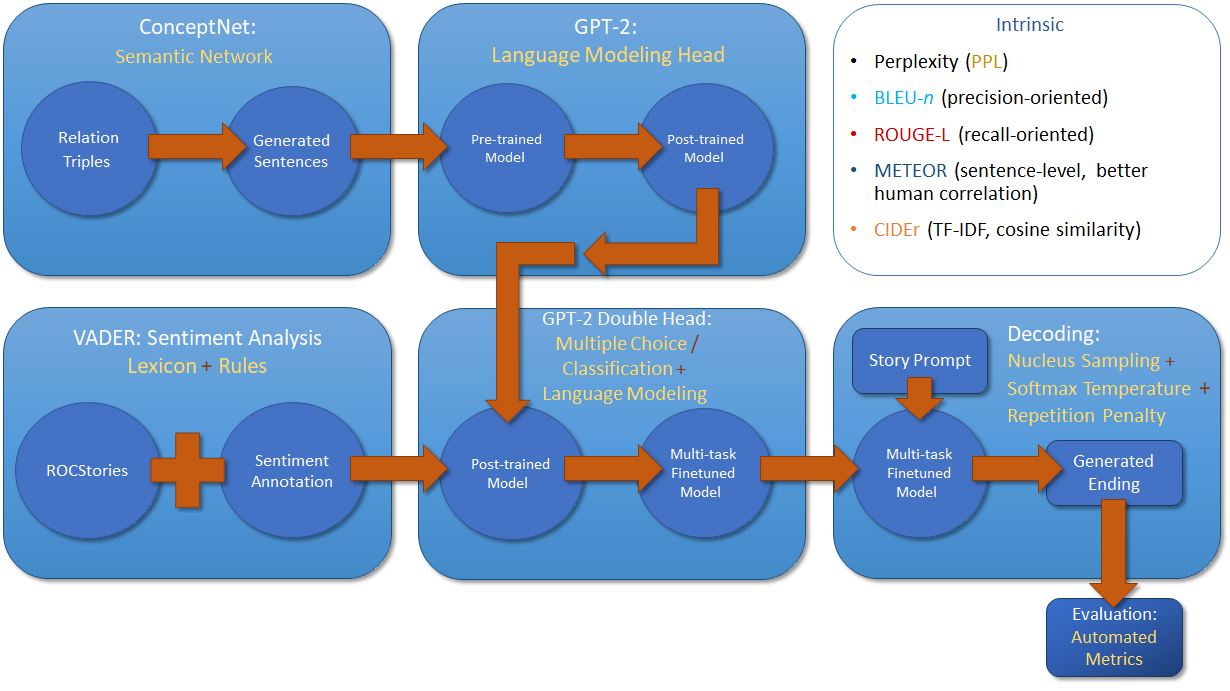

#### A. Automated metrics
* BLEU, ROUGE, METEOR, CIDEr 
* Perplexity
* Distinct
* Skip Thought
* GloVe
* Readability
* Entity Coherence

In [0]:

def display_df_evals(model_type: str):
    """Display metrics results with emphasis on min/max vals."""
    print(f"Evaluations for {model_type}:\n")
    def bold_max(s): 
        """"Bold largest values.""" 
        is_max = s == s.max()
        return ['font-weight: bold' if v else '' for v in is_max]

    def ital_min(s):
        """"Italicize smallest values.""" 
        is_min = s == s.min()
        return ['font-style: italic' if v else '' for v in is_min]
    # TODO: More efficient selection... 
    try:
        all_evals_df = pd.read_csv(f"evals/{model_type}_all_evals.txt", sep=',') # Overlap/distinct per story.
    except:
        pass
    try:
        skip_evals_df = pd.read_csv(f"evals/{model_type}_sg_skip_evals.txt", sep=',') # Skip-thought.
    except:
        pass
    try:
        glove_evals_df = pd.read_csv(f"evals/{model_type}_sg_glove_evals.txt", sep=',') # GloVe.
    except:
        pass
    try:
        ppl_df = pd.read_csv(f"evals/{model_type}_ppl.csv", sep=',') # Perplexity.
    except:
        pass
    try:
        corpus_df = pd.read_csv(f"evals/{model_type}_corpus_all.txt", sep=',') # Overlap, corpus level.
    except:
        pass
    try:
        corefs_df = pd.read_csv(f"evals/{model_type}_trunc_corefs.csv", sep=',', usecols=[1, 2, 3]) # Entity coreference.
    except:
        pass
    try:
        read_df = pd.read_csv(f"evals/{model_type}_joint_readability.txt", sep=',')
    except:
        pass
    try:
        skip_glove_evals_df = glove_evals_df.join(skip_evals_df)
    except:
        pass
    try:
        print("Overlap, Distinct:\n")
        all_evals_df = all_evals_df.head().style.\
                                apply(bold_max).\
                                apply(ital_min)
        display(all_evals_df.head())
        print("\n")
    except:
        pass
    try:
        print("Skip-Thought/GloVe:\n")
        display(skip_glove_evals_df)
        print("\n")
    except:
        pass
    try:
        print("Perplexity:\n")
        display(ppl_df.head())
        print("\n")
    except:
        pass
    try:
        print("Corpus-level overlap:\n")
        display(corpus_df)
        print("\n")
    except:
        pass
    try:
        print("Readability:\n")
        display(read_df.mean().head()) # Flesch-Kincaid
        print("\n")
    except:
        pass
    try:
        print("Entity coreference:\n")
        display(corefs_df) # Results on truncated batch.
    except:
        pass
    try:
        return ppl_df.loc[0, :]
    except:
        return pd.DataFrame()

Choose model and display results:
* Currently may error out if model evaluation file missing (not computed).

In [0]:
display_dfe = interactive(display_df_evals,
                          {'manual': True, 
                           'manual_name': 'Load/display results'},
                          model_type=Dropdown(options=[
                                            ('Base to SCT', 'b_SCT'),
                                            ('ConceptNet to SCT', 'cn_SCT'), #
                                            ('ConceptNet to Sentiment', 'cn_sentiment'), #
                                            ('CN to SCT to Sentiment', 'cn_SCT_sentiment'),
                                            ('CN to Sentiment to SCT', 'cn_sentiment_SCT'),
                                            ('ROC to SCT to Sentiment', 'roc1617_SCT_sentiment'),
                                            ('ROC to Sentiment to SCT', 'roc1617_sentiment_SCT'),
                                            ('ROC to SCT', 'roc1617_SCT')],
                                              description="Model type"))

display_dfe.layout.height = "350px"
display(display_dfe)

#### B. Compute Perplexity
* Requires loaded model, tokenizer \[III.A], and: (gen_stories \[III.B.a] _or_ perplexity evaluation dataframe loaded from file \[IV.A.]).
* Subsection _b_ required for visualizations in section V.

Set perplexity dataframe from results in IV.A if not running below computations:

In [0]:
if display_dfe.result.any():
    ppl_df = display_dfe.result

##### a) Define computation
* Compute perplexity which obtained above results:

In [0]:
def compute_gen_ppl(gen: str, cref: str, model, tokenizer) -> dict:
    """Compute perplexity on generated, correct endings."""
    input_ids_gen = torch.tensor(tokenizer.encode(gen, add_special_tokens=False)).unsqueeze(0).to("cuda")  # Batch size 1
    input_ids_cref = torch.tensor(tokenizer.encode(cref, add_special_tokens=False)).unsqueeze(0).to("cuda")

    with torch.no_grad():
        outputs_gen = model(input_ids_gen, lm_labels=input_ids_gen)
        loss_gen, logits_gen, _, _, attns = outputs_gen # lm_loss, lm_logits, mc_logits, presents, attns
        outputs_cref = model(input_ids_cref, lm_labels=input_ids_cref)
        loss_cref = outputs_cref[0]

    perplexity_gen = torch.exp(torch.tensor(loss_gen.item()))
    perplexity_cref = torch.exp(torch.tensor(loss_cref.item()))
    genl = gen.split("_delimiter_")[-1]
    crefl = cref.split("_delimiter_")[-1]
    ppl_res = [perplexity_cref.item(), perplexity_gen.item()]
    return ppl_res, logits_gen, attns, crefl, genl

def display_ppl(gen_stories: list, model, tokenizer) -> None:
    """Collect each story's perplexity results for generated, correct endings."""
    df_endings_list = df_endings.values.tolist()
    ppl_results = []
    ppl_df = pd.DataFrame()
    for ix, story in enumerate(gen_stories):
        story = story.split("\t")
        try:
            gen_end = story[2]
        except:
            gen_end = "_none_"
        story_body = "_start_" + story[0]
        gen = story_body + "_delimiter_" + gen_end
        cref = story_body + "_delimiter_" + df_endings_list[ix]
        ppl_res, logits_gen, attns, crefl, genl = compute_gen_ppl(gen, cref, model, tokenizer)
        ppl_df.loc[ix, 'ppl_corr'] = ppl_res[0]
        ppl_df.loc[ix, 'ppl_gen'] = ppl_res[1]
        ppl_results.append([logits_gen[0, 0, :50].cpu(), story_body, (crefl, genl)])
    # Return gen/corr ppl; small batch of logits for softmax viz, the rest for attn viz.
    return ppl_df, ppl_results

Perplexity dataframe will be freshly computed or set from file:

In [0]:
try:
    if gen_stories:
        print(gen_stories)
except:
    gen_stories = [ppl_df.Story]

##### b) Run computation 
* To obtain logits; set prompt/endings for visualizations.

In [0]:
ppl_disp = interactive(display_ppl, 
                       {'manual': True, 
                        'manual_name': 'Get perplexities'}, 
                       gen_stories=fixed(gen_stories),
                       model=fixed(model),
                       tokenizer=fixed(tokenizer))
ppl_disp.layout.height = "250px"
display(ppl_disp)

In [0]:
if ppl_disp.result:
    ppl_df, results = ppl_disp.result # Get first story results for viz.
logits, prompt, endings = results[0]
ending = endings[0] # correct ending

Combine PPL with endings, write to file.

In [0]:
try:
    df_ppl = res_df.join(ppl_df)
except:
    pass

In [0]:
ppl_df

## V. Visualization
> A. Softmax

> B. Attention

* <small>Requires subsection IV.B.b</small>
* <small>See seg_analysis.ipynb for more concise, updated functions.

### A. Interactive sampling visualization
* Requires logits from Perplexity section (IV.B).

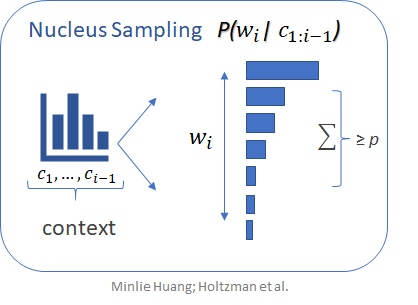

#### a) Define softmax visualization functions

Get logits after nucleus filtering:

In [0]:
old_logits = logits.clone() # Avoid zany side-effects from visualization functions.
top_p = 0.9
top_k = 20

# From HuggingFace
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (batch size, vocabulary size)
            if top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
            Make sure we keep at least min_tokens_to_keep per batch example in the output
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # Scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(-1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

p_logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)

In [0]:
def softmax(temperature):
    """Softmax w/ temp for logits."""
    global old_logits
    v = len(old_logits)
    plt.figure(figsize=(8,5))
    plt.title("Softmax distribution w/ temperature")
    plt.xlabel("Vocabulary")
    plt.ylabel("Probability")
    probs = F.softmax(old_logits/temperature, dim=-1)
    plt.bar(range(v),
            probs, 
            facecolor='cyan', 
            edgecolor='blue')
    sample = torch.multinomial(probs, num_samples=v)
    next_token = tokenizer.decode(sample)
    plt.xticks(sample, next_token)
    
def softmaxp(temperature):
    """Softmax w/ temp for truncated logits."""
    global p_logits
    v = len(p_logits)
    plt.figure(figsize=(8,5))
    plt.title(f"Truncated distribution w/ temperature; k: {top_k}, p: {top_p}")
    plt.xlabel("Vocabulary")
    plt.ylabel("Probability")
    probs = F.softmax(p_logits/temperature, dim=-1)
    plt.bar(range(v), 
            probs, 
            facecolor='magenta', 
            edgecolor='purple')
    sample = torch.multinomial(probs, replacement=True, num_samples=v)
    next_token = tokenizer.decode(sample)
    plt.xticks(sample, next_token)

#### b) Display interactive sampling visualization

In [0]:
w = interactive(softmax, 
                temperature=FloatSlider(min=0.1, 
                                        max=10.01, 
                                        step=0.1, 
                                        description='Temperature:', 
                                        value=1.0, 
                                        continuous_update=False))
y = interactive(softmaxp, 
                temperature=FloatSlider(min=0.1, 
                                        max=10.01, 
                                        step=0.1, 
                                        description='Temperature:', 
                                        value=1.0, 
                                        continuous_update=False))

w.layout.height = '450px'
y.layout.height = '450px'
display(w, y)

### B. Attention maps
* Requires prompt, ending from Perplexity section (IV.B).

#### a) Define attention map functions

In [0]:
def get_attns(prompt: str, ending: str):
    """Get attention weights for story."""
    prompt_tokens = tokenizer.tokenize(prompt)
    end_tokens = tokenizer.tokenize(ending)
    pos_token = len(prompt_tokens)
    in_tokens = prompt_tokens + end_tokens
    in_tokens = list(map(lambda w: w.replace("Ġ", ""), in_tokens))
    ids = torch.tensor(tokenizer.convert_tokens_to_ids(in_tokens)).unsqueeze(0).to('cuda')
    with torch.no_grad():
        output = model(ids)
    attentions = torch.cat(output[-1]).cpu()
    attentions = attentions.permute(2,1,0,3)
    return in_tokens, pos_token, attentions

def display_attns(in_tokens, attns, pos_token):
    "Displays multi-head attention weights for a token."
    heads = len(attns[0])
    cols = 2
    rows = int(heads/cols)
    fig, axes = plt.subplots(rows, cols, figsize = (27, 27))
    fig.tight_layout(pad=5.0)
    axes = axes.flat
    attentions_pos = attns[pos_token]
    cp = " ".join(in_tokens[pos_token-1:pos_token])
    ca = " ".join(in_tokens[pos_token+1:pos_token+2])
    context = cp + f" {in_tokens[pos_token]} " + ca
    print(f'\nMultihead attention weights:')
    for i, att in enumerate(attentions_pos):
        sns.heatmap(att, vmin = 0, vmax = 1, ax = axes[i], xticklabels = in_tokens)
        axes[i].set_title(f'Head #{i+1} ' )
        axes[i].set_ylabel('Layers')
        for tick in axes[i].get_xticklabels():
                tick.set_rotation(45)
                tick.set_fontsize(8) 

def display_per_head_attn(in_tokens, attns, pos_token, head):
    "Given head number and position index, displays attention weights for a token."
    head = head -1
    fig, axes = plt.subplots(figsize = (20, 8))
    fig.tight_layout(pad=5.0)
    attentions_pos = attns[pos_token]
    cp = " ".join(in_tokens[pos_token-1:pos_token])
    ca = " ".join(in_tokens[pos_token+1:pos_token+2])
    context = cp + f" {in_tokens[pos_token]} " + ca
    print(f'\nHeadwise attention weights:')
    sns.heatmap(attentions_pos[head], 
                vmin = 0, vmax = 1, 
                xticklabels = in_tokens)
    axes.set_title(f'Head #{head + 1} ' )
    axes.set_ylabel('Layers')
    for ix, tick in enumerate(axes.get_xticklabels()):
            tick.set_rotation(55)
            tick.set_fontsize(9) 
            if tick.get_text() == in_tokens[pos_token]:
                try:
                    if axes.get_xticklabels()[ix+1].get_text() == ca:
                        if axes.get_xticklabels()[ix-1].get_text() == cp:
                            tick.set_color("magenta")
                            tick.set_fontsize(10)
                except:
                    tick.set_color("magenta")
                    tick.set_fontsize(10)

def display_per_layer_attn(in_tokens, attns, pos_token, layer):
    "Given layer number and position index, displays attention weights for a token."
    layer -= 1
    fig, axes = plt.subplots(figsize = (20, 8))
    fig.tight_layout(pad=5.0)
    attns = attns.permute(0, 2, 1, 3)
    attentions_pos = attns[pos_token]
    cp = " ".join(in_tokens[pos_token-1:pos_token])
    ca = " ".join(in_tokens[pos_token+1:pos_token+2])
    context = cp + f" {in_tokens[pos_token]} " + ca
    print(f'\nLayerwise attention weights:')
    sns.heatmap(attentions_pos[layer], 
                vmin = 0, vmax = 1, 
                xticklabels = in_tokens)
    axes.set_title(f'Layer #{layer + 1} ' )
    axes.set_ylabel('Heads')
    for ix, tick in enumerate(axes.get_xticklabels()):
            tick.set_rotation(55)
            tick.set_fontsize(9) 
            if tick.get_text() == in_tokens[pos_token]:
                try:
                    if axes.get_xticklabels()[ix+1].get_text() == ca:
                        if axes.get_xticklabels()[ix-1].get_text() == cp:
                            tick.set_color("magenta")
                            tick.set_fontsize(10)
                except:
                    tick.set_color("magenta")
                    tick.set_fontsize(10)

def display_per_layer_per_head_attn(in_tokens, attns, pos_token, layer, head):
    "Given head, layer number and position index, displays attention weights for a token."
    layer -= 1
    head -= 1
    fig, axes = plt.subplots(figsize = (20, 1))
    attns = attns.permute(0, 2, 1, 3)
    attentions_pos = attns[pos_token]
    cp = " ".join(in_tokens[pos_token-1:pos_token])
    ca = " ".join(in_tokens[pos_token+1:pos_token+2])
    context = cp + f" {in_tokens[pos_token]} " + ca
    print(f'\nLayerwise attention weights for given head:')
    sns.heatmap(attentions_pos[layer][head].reshape(1, -1), 
                vmin = 0, vmax = 1, 
                xticklabels = in_tokens)
    axes.set_title(f'Layer #{layer + 1} ' )
    axes.set_ylabel(f'Head #{head + 1}')
    for ix, tick in enumerate(axes.get_xticklabels()):
            tick.set_rotation(55)
            tick.set_fontsize(9) 
            if tick.get_text() == in_tokens[pos_token]:
                try:
                    if axes.get_xticklabels()[ix+1].get_text() == ca:
                        if axes.get_xticklabels()[ix-1].get_text() == cp:
                            tick.set_color("magenta")
                            tick.set_fontsize(10)
                except:
                    tick.set_color("magenta")
                    tick.set_fontsize(10)


def display_per_head_attn_alt(in_tokens, attns, pos_token, head):
    "Given head number and position index, displays attention weights for a token."
    head -= 1
    fig, axes = plt.subplots(figsize = (20, 8))
    fig.tight_layout(pad=5.0)
    attentions_pos = attns[pos_token]
    cp = " ".join(in_tokens[pos_token-1:pos_token])
    ca = " ".join(in_tokens[pos_token+1:pos_token+2])
    context = cp + f" {in_tokens[pos_token]} " + ca
    print(f'\nHeadwise attention weights:')
    plt.imshow(attentions_pos[head])
    plt.xticks(range(len(in_tokens)), in_tokens, rotation=45)
    plt.title(f'Head #{head + 1} ' )
    plt.ylabel('Layers')
    plt.show()
    return None

def display_avg_attn(in_tokens, attns, pos_token):
    """Display mean attention weights for token."""
    fig, axes = plt.subplots(figsize = (20, 8))
    fig.tight_layout(pad=5.0)
    attentions_pos = attns[pos_token]
    cp = " ".join(in_tokens[pos_token-1:pos_token])
    ca = " ".join(in_tokens[pos_token+1:pos_token+2])
    context = cp + f" {in_tokens[pos_token]} " + ca
    avg_attn = attentions_pos.mean(dim=0)
    plt.title(f'\nAverage attention weights')
    sns.heatmap(avg_attn, vmin = 0, vmax = 1, xticklabels = in_tokens)
    axes.set_ylabel('Layers')
    plt.xticks(rotation=55, fontsize=8)
    for ix, tick in enumerate(axes.get_xticklabels()):
        if tick.get_text() == in_tokens[pos_token]:
            try:
                if axes.get_xticklabels()[ix+1].get_text() == ca:
                    if axes.get_xticklabels()[ix-1].get_text() == cp:
                        tick.set_color("magenta")
                        tick.set_fontsize(10)
            except:
                tick.set_color("magenta")
                tick.set_fontsize(10)
    plt.show()

def display_avg_attn_per_layer(in_tokens, attns, pos_token, layer):
    """Display mean attention weights for token per layer."""
    layer -= 1
    fig, axes = plt.subplots(figsize = (20, 1))
    attns = attns.permute(0, 2, 1, 3)
    attentions_pos = attns[pos_token]
    cp = " ".join(in_tokens[pos_token-1:pos_token])
    ca = " ".join(in_tokens[pos_token+1:pos_token+2])
    context = cp + f" {in_tokens[pos_token]} " + ca
    avg_attn = attentions_pos[layer].mean(dim=0)
    print(f'\nPer-layer average attention weights')
    sns.heatmap(avg_attn.reshape(1, -1), vmin = 0, vmax = 1, xticklabels = in_tokens)
    axes.set_title(f'Layer #{layer + 1} ' )
    axes.set_ylabel('Heads (avg)')
    plt.xticks(rotation=55, fontsize=8)
    for ix, tick in enumerate(axes.get_xticklabels()):
        if tick.get_text() == in_tokens[pos_token]:
            try:
                if axes.get_xticklabels()[ix+1].get_text() == ca:
                    if axes.get_xticklabels()[ix-1].get_text() == cp:
                        tick.set_color("magenta")
                        tick.set_fontsize(10)
            except:
                tick.set_color("magenta")
                tick.set_fontsize(10)
    plt.show()

#### b) Get attention weights

In [0]:
attn_vars = interactive(get_attns, 
                        {'manual': True, 
                         'manual_name': 'Get attention weights'}, 
                        prompt=fixed(prompt), 
                        ending=fixed(ending))
display(attn_vars)

In [0]:
if attn_vars.result:
    in_tokens, pos_token, attns = attn_vars.result

#### c) Display interactive attention maps

Display attention weights for all heads (slow):

In [0]:
dph_all = interactive(display_attns, 
                      {'manual': True,
                       'manual_name': 'Display attns (all)'},
                        in_tokens=fixed(in_tokens), 
                        attns=fixed(attns), 
                        pos_token=IntSlider(min=0, 
                                            max=len(in_tokens)-1, 
                                            step=1, 
                                            description='position:', 
                                            value=1, 
                                            continuous_update=False))
                                      
display(dph_all)

Display attention weights for a single head:

In [0]:
dph = interactive(display_per_head_attn, 
                  in_tokens=fixed(in_tokens), 
                  attns=fixed(attns), 
                  pos_token=IntSlider(min=0, 
                                      max=len(in_tokens)-1, 
                                      step=1, 
                                      description='position:', 
                                      value=1, 
                                      continuous_update=False), 
                  head=IntSlider(min=1, 
                                 max=12, 
                                 step=1, 
                                 description='head:', 
                                 value=12, 
                                 continuous_update=False))
dph.layout.height = '650px'
display(dph)

Display attention weights for a single layer:

In [0]:
dpl = interactive(display_per_layer_attn, 
                  in_tokens=fixed(in_tokens), 
                  attns=fixed(attns), 
                  pos_token=IntSlider(min=0, 
                                      max=len(in_tokens)-1, 
                                      step=1, 
                                      description='position:', 
                                      value=1, 
                                      continuous_update=False), 
                  layer=IntSlider(min=1, 
                                 max=12, 
                                 step=1, 
                                 description='layer:', 
                                 value=12, 
                                 continuous_update=False))
dpl.layout.height = '650px'
display(dpl)

Display attention weights per layer, per head:

In [0]:
dplh = interactive(display_per_layer_per_head_attn, 
                  in_tokens=fixed(in_tokens), 
                  attns=fixed(attns), 
                  pos_token=IntSlider(min=0, 
                                      max=len(in_tokens)-1, 
                                      step=1, 
                                      description='position:', 
                                      value=1, 
                                      continuous_update=False), 
                  layer=IntSlider(min=1, 
                                 max=12, 
                                 step=1, 
                                 description='layer:', 
                                 value=12, 
                                 continuous_update=False),
                  head=IntSlider(min=1, 
                                 max=12, 
                                 step=1, 
                                 description='head:', 
                                 value=12, 
                                 continuous_update=False))
dplh.layout.height = '300px'
display(dplh)

Display attention weights averaged over all heads:

In [0]:
dph_avg = interactive(display_avg_attn, 
                  in_tokens=fixed(in_tokens), 
                  attns=fixed(attns), 
                  pos_token=IntSlider(min=0, 
                                      max=len(in_tokens)-1, 
                                      step=1, 
                                      description='position:', 
                                      value=1, 
                                      continuous_update=False))
dph_avg.layout.height = '650px'
display(dph_avg)

Display attention weights averaged over all heads, per layer:

In [0]:
dph_avg_l = interactive(display_avg_attn_per_layer, 
                  in_tokens=fixed(in_tokens), 
                  attns=fixed(attns), 
                  pos_token=IntSlider(min=0, 
                                      max=len(in_tokens)-1, 
                                      step=1, 
                                      description='position:', 
                                      value=1, 
                                      continuous_update=False), 
                  layer=IntSlider(min=1, 
                                 max=12, 
                                 step=1, 
                                 description='layer:', 
                                 value=12, 
                                 continuous_update=False))
dph_avg_l.layout.height = '650px'
display(dph_avg_l)